In [45]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler


# Loading the Dataset

In [3]:
file_path = 'C:/Users/Joe/Desktop/UNI/Yr3/Dissertation/Datasets/101_ObjectCategories'
folder_names = []
folder_names = [f for f in sorted(os.listdir(file_path))]

print(len(folder_names))  # 102 = 101 categories + background


102


C:\Users\Joe\AppData\Local\Temp\ipykernel_9436\2155978937.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


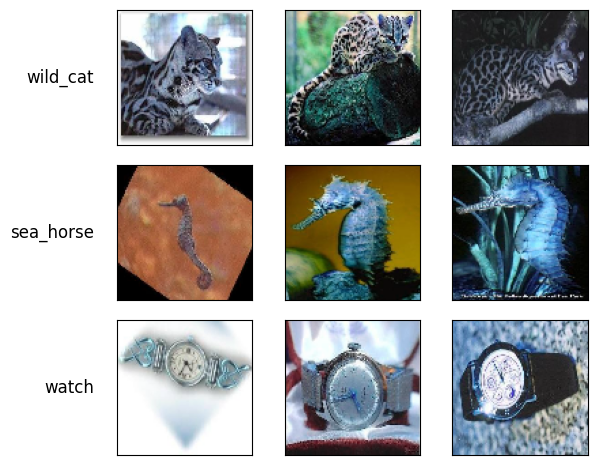

In [76]:
num_categories = 3
num_imgs = 3 
selected_categories = np.random.randint(0,101, num_categories, dtype="I")

fig, ax = plt.subplots(nrows=num_categories, ncols=num_imgs)

fig.subplots_adjust(wspace=0.1,hspace=0.1)

for a, cat in enumerate(selected_categories):
    folder_path = file_path + '/' + folder_names[cat]
    image_names = [a for a in sorted(
        os.listdir(folder_path))][:num_imgs]
    
    for b, img_name in enumerate(image_names):
        img_path = folder_path + '/' + img_name
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        ax[a, b].imshow(img)
        ax[a, b].set_xticks([])
        ax[a, b].set_yticks([])
        
        if b == 0:
            pad = 5  # in points
            #ax[i,j].set_ylabel(folder_names[category], rotation=0, size='large')
            ax[a,b].annotate(folder_names[cat], xy=(0, 0.5), xytext=(-ax[a,b].yaxis.labelpad - pad, 0),
                xycoords=ax[a,b].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        
fig.tight_layout()
#plt.axis('off')
fig.show()


In [35]:
img_data = []
num_categories = 6
num_imgs = 9
selected_categories = np.random.randint(0,101, num_categories, dtype="I")

for a, cat in enumerate(selected_categories):
    folder_path = file_path + '/' + folder_names[cat]
    image_names = [a for a in sorted(
        os.listdir(folder_path))][:num_imgs]

    for b, img_name in enumerate(image_names):
        img_path = folder_path + '/' + img_name
        img = cv2.imread(img_path)
        img = cv2.resize(img, (100, 100))
        
        if img is not None:
            img_data.append(img)
       


# Global Functions

In [46]:
def normalise(distances, scale):
    scaler = MinMaxScaler((0, scale))
    keys = distances.keys()
    distances = np.array(list(distances.values()))
    distances = scaler.fit_transform(distances.reshape(-1, 1))
    distances = dict(zip(keys, distances))
    return distances

# Histogram features

In [49]:
def histogram_features(img):
    features = [] 
    pp_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    channels = cv2.split(pp_img)
    channel_names = ('h', 's', 'v')
    for (channel, channel_name) in zip(channels, channel_names):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        features.extend(hist.flatten())
        return features

In [43]:
def hist_features_database(data_imgs):
    db_features = []
    for img in data_imgs:
        db_features.append(histogram_features(img))
    db_hist_df = DataFrame(db_features)
    return db_hist_df

In [47]:
def calc_hist_distance(query_img, db_df):
    feature_vectors = db_df.values.tolist()
    distances = {}
    for a in range(len(feature_vectors)):
        query_features = histogram_features(query_img)
        dist = euclidean(query_features, feature_vectors[a])
        distances[a] = dist
    return normalise(distances, 20)

# Gabor Features

In [63]:
def build_filters():
    filters = []
    kernal_size = 9 
    for theta in np.arange(0, np.pi, np.pi / 8):
        for deg in np.arange(0, 6*np.pi/4, np.pi / 4):
            kernal = cv2.getGaborKernel((kernal_size, kernal_size), 1.0, theta, deg, 0.5, 0, ktype= cv2.CV_32F)
            kernal /= 1.5 * kernal.sum()
            filters.append(kernal)
    return filters

In [58]:
def convolve_filters(img, filters):
    conv = np.zeros_like(img)
    for kernal in filters:
        filter_img = cv2.filter2D(img, cv2.CV_8UC3, kernal)
        np.maximum(conv, filter_img, conv)
    return conv

In [59]:
def gabor_features(img):
    features = []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    filters = np.asarray(build_filters())
    
    for a in range(20):
        energy = 0
        conv = convolve_filters(img, filters[a])
        for b in range(100):
            for c in range(100):
                energy += conv[b][c] * conv[b][c]
        features.append(energy)
    for a in range(20):
        mean = 0
        conv = convolve_filters(img, filters[a])
        for b in range(100):
            for c in range(100):
                mean += abs(conv[a][b])
        features.append(mean)
    features = np.array(features)
    return features

In [60]:
def gabor_features_database(data_imgs):
    db_feat = []
    for img in data_imgs:
        db_feat.append(gabor_features(img))
    db_gabor_df = DataFrame(db_feat)
    return db_gabor_df

In [61]:
def calc_gabor_distance(query_img, db_df):
    distances = {}
    query_feat = gabor_features(query_img)
    feature_vector = db_df.values.tolist()
    
    for a in range(len(feature_vector)):
        distances[a] = euclidean(query_feat, feature_vector[a])
    distances = normalise(distances, 20)
    return distances

# Distance Metric Calculation

In [70]:
def calc_distances_total(hist_dist, gabor_dist):
    total_dist = []
    hist_weight = 0.8
    gabor_weight = 0.2
    
    for a in hist_dist:
        hist_dist[a] *= hist_weight
        gabor_dist[a] *= gabor_weight
        total_dist.append(hist_dist[a] + gabor_dist[a])  
    return np.array(total_dist)

In [71]:
query_img = img_data[0]

hist_dist = calc_hist_distance(query_img, hist_features_database(img_data))
gabor_dist = calc_gabor_distance(query_img, gabor_features_database(img_data))

final_dist = calc_distances_total(hist_dist, gabor_dist)

C:\Users\Joe\AppData\Local\Temp\ipykernel_9436\2817687033.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  energy += conv[b][c] * conv[b][c]


In [73]:
final_dist


array([[ 0.        ],
       [13.84348089],
       [13.77900287],
       [ 4.80448384],
       [ 4.87729491],
       [16.17666018],
       [ 4.45721001],
       [12.39232312],
       [ 9.13117413],
       [13.28712508],
       [ 5.66413649],
       [ 7.39235071],
       [ 3.02138273],
       [12.03377337],
       [13.73222248],
       [13.35063198],
       [14.25583181],
       [12.37290822],
       [14.42385988],
       [12.98315915],
       [ 5.24752385],
       [13.77373253],
       [14.51672263],
       [15.23213234],
       [14.87565187],
       [12.617547  ],
       [13.55132151],
       [ 6.38292751],
       [14.84345663],
       [11.14193747],
       [11.79273293],
       [13.73725935],
       [ 4.82086613],
       [15.13309991],
       [13.33364036],
       [12.26985813],
       [13.20918662],
       [13.04834422],
       [ 5.82097059],
       [14.32963325],
       [11.92961893],
       [13.64124511],
       [12.16232303],
       [12.82453461],
       [ 6.44139167],
       [12